# Importações

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import matplotlib.dates as mdates
import locale

# Dados Meteo

In [2]:
# Adiciona a pasta-pai ao sys.path (para importar meteorology)
sys.path.append(os.path.abspath(".."))
from meteorology.data.meteorology_data import GetMeteorologyData
df = GetMeteorologyData()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29973 entries, 0 to 29972
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          29973 non-null  datetime64[ns]
 1   temp              29973 non-null  float64       
 2   feelslike         29973 non-null  float64       
 3   dew               29973 non-null  float64       
 4   humidity          29973 non-null  float64       
 5   precip            28966 non-null  float64       
 6   precipprob        29973 non-null  float64       
 7   preciptype        804 non-null    object        
 8   windgust          2088 non-null   float64       
 9   windspeed         29966 non-null  float64       
 10  winddir           29790 non-null  float64       
 11  sealevelpressure  29973 non-null  float64       
 12  cloudcover        22653 non-null  float64       
 13  visibility        29967 non-null  float64       
 14  conditions        2997

In [3]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

# Selecionar só as colunas temp e precip e fazer o resample diário com média
df = df[['temp', 'precip']].resample('D').mean()

### contadores corrigidos

In [4]:
df_corrigido_final = pd.read_csv(r"C:\Users\joana\Desktop\Projeto\construcao_modelos\df_corrigido_final.csv")

### Theil

In [5]:
def entropia_semanal(df, coluna='count_', plotar=True, data_inicio='2021-08-02', data_fim='2024-02-25'):
    from scipy.stats import entropy
    df = df.copy()
    df = df.set_index('datetime')

    data_inicio = pd.to_datetime(data_inicio)
    data_fim = pd.to_datetime(data_fim)
    df = df[(df.index >= data_inicio) & (df.index <= data_fim)]

    def calcular_entropia(x):
        x = np.array(x)
        if x.sum() == 0:
            return np.nan
        p = x / x.sum()
        return entropy(p, base=np.e)

    df_entropia = (
        df[coluna]
        .resample('W-MON')
        .apply(calcular_entropia)
        .reset_index(name='entropia')
    )

    # Calcular Theil (T) e Redundância relativa (R)
    df_entropia['T'] = np.log(7) - df_entropia['entropia']
    df_entropia['R'] = df_entropia['T'] / np.log(7)

    # Ano e semana ISO
    df_entropia['ano'] = df_entropia['datetime'].dt.isocalendar().year
    df_entropia['semana'] = df_entropia['datetime'].dt.isocalendar().week

    # Remover primeira e última semanas
    df_entropia = df_entropia.sort_values('datetime').iloc[1:-1].reset_index(drop=True)

    if plotar:
        plt.figure(figsize=(12, 15))

        for i, (col, title, ylabel) in enumerate([
            ('entropia', 'Entropia por Semana e Ano', 'Entropia'),
            ('T', 'Índice de Theil T por Semana e Ano', 'T'),
            ('R', 'Redundância Relativa R por Semana e Ano', 'R')
        ]):
            plt.subplot(3, 1, i+1)
            for ano in sorted(df_entropia['ano'].unique()):
                subset = df_entropia[df_entropia['ano'] == ano]
                plt.plot(subset['semana'], subset[col], marker='o', linestyle='-', label=f'Ano {ano}', alpha=0.7)
            plt.xlim(1, 53)
            plt.title(title)
            plt.xlabel('Semana do Ano')
            plt.ylabel(ylabel)
            plt.grid(True)
            plt.legend()

        plt.tight_layout()
        plt.show()

    return df_entropia

In [7]:
df_corrigido_final = df_corrigido_final.rename(columns={'detected': 'datetime'})
df_corrigido_final['datetime'] = pd.to_datetime(df_corrigido_final['datetime'])

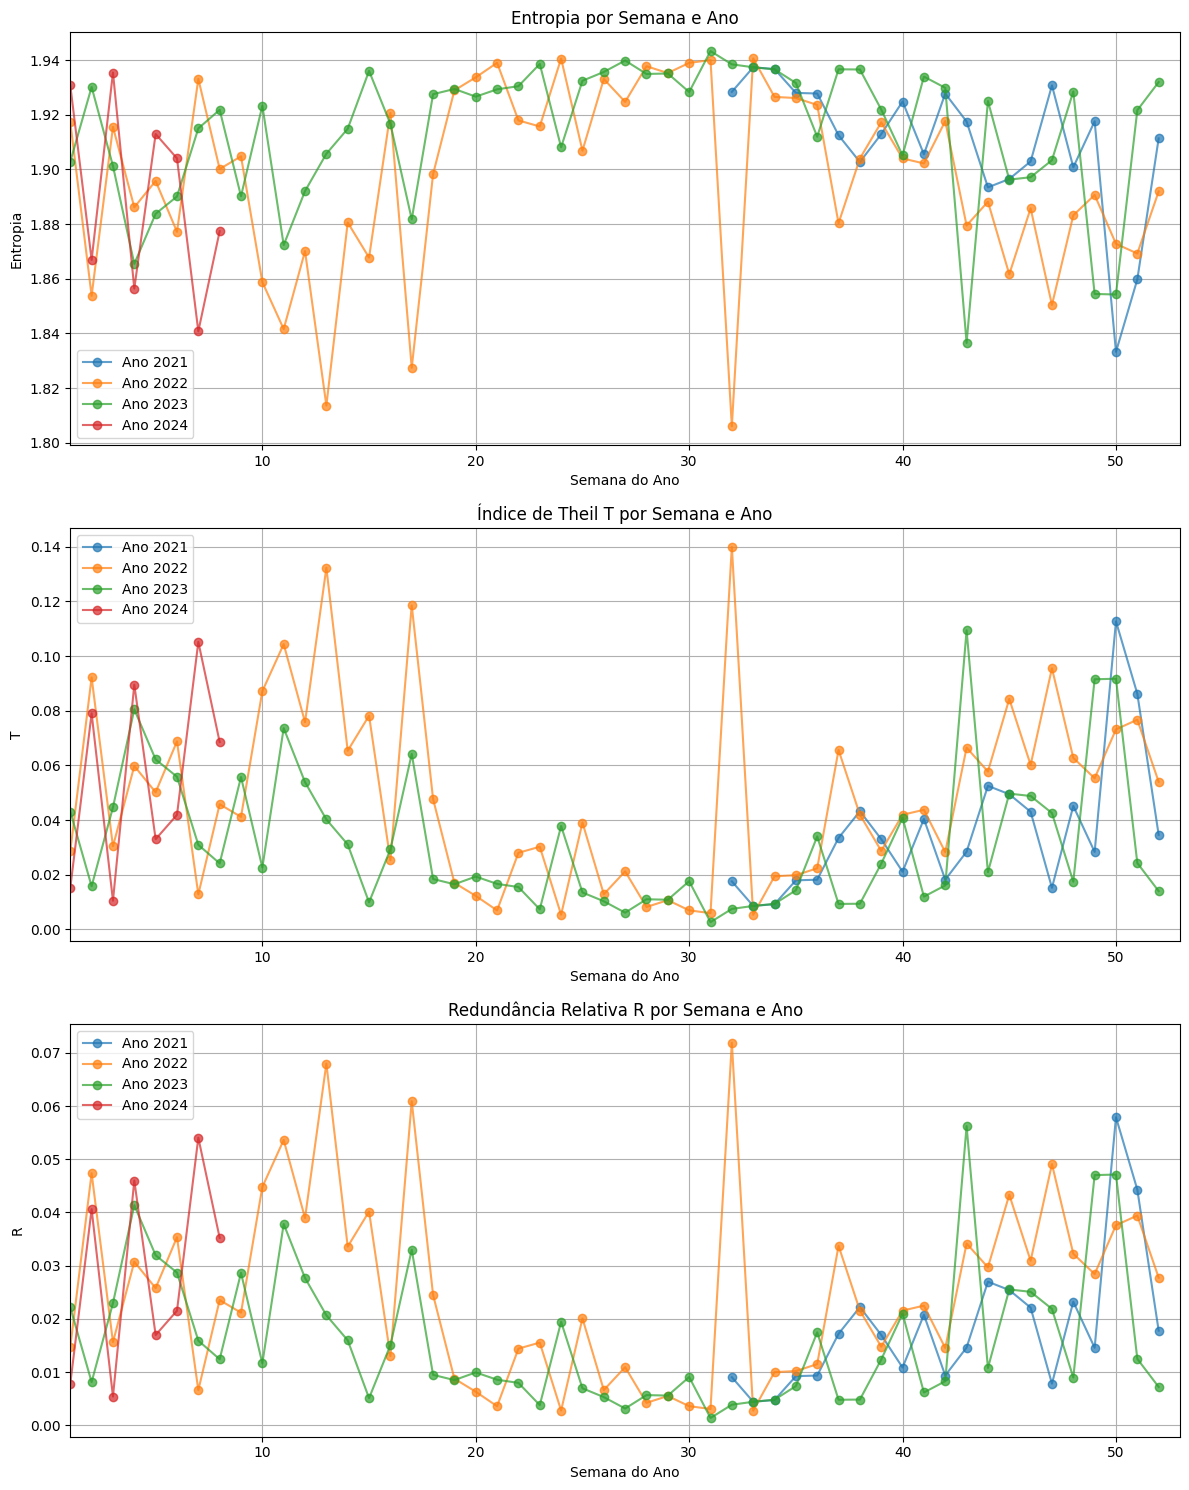

In [21]:
df_entorpia_12 = entropia_semanal(df_corrigido_final, coluna='count_12', plotar=True )

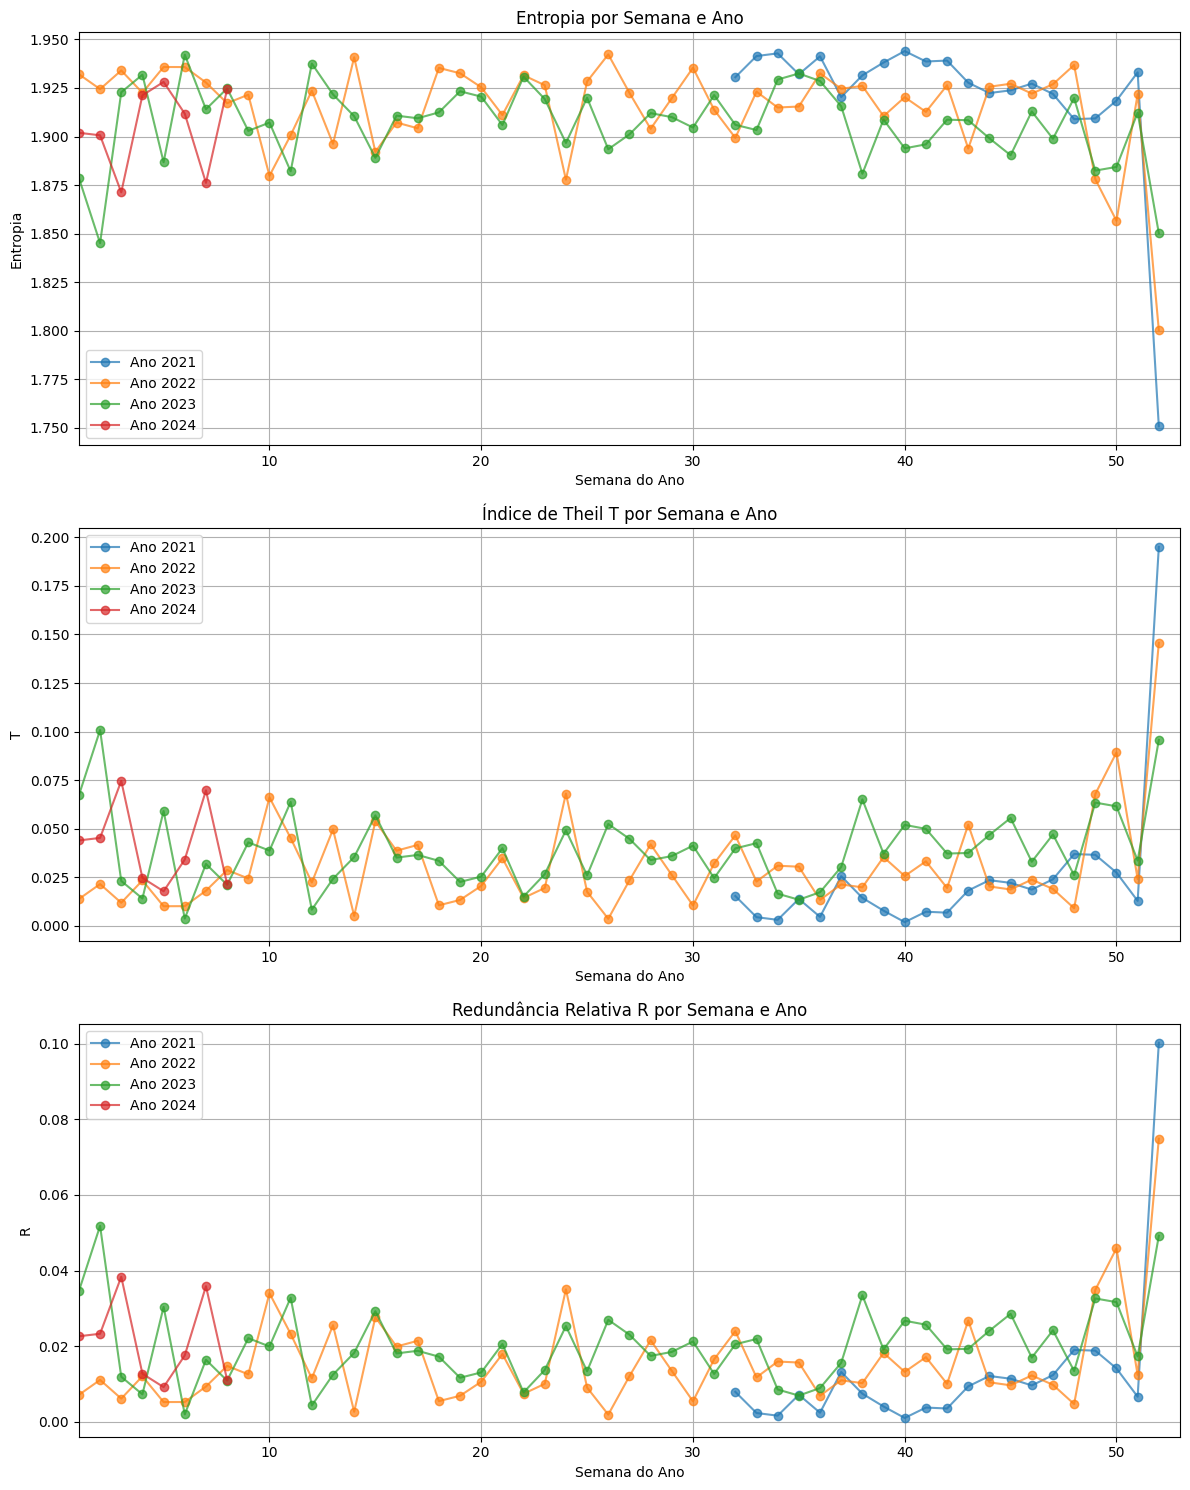

In [22]:
df_entorpia_8 = entropia_semanal(df_corrigido_final, coluna='count_8', plotar=True )

### Theil + meteo

In [13]:
df.index = pd.to_datetime(df.index)
df_meteo_semanal = df.resample('W-MON').mean().reset_index()
df_meteo_semanal.columns = ['semana_data', 'temp', 'precip'] 

In [23]:
df_entorpia_12.rename(columns={'datetime': 'semana_data'}, inplace=True)
df_entorpia_8.rename(columns={'datetime': 'semana_data'}, inplace=True)

In [24]:
df_merged_count12 = pd.merge(df_entorpia_12, df_meteo_semanal, on='semana_data', how='left')

In [25]:
df_merged_count8 = pd.merge(df_entorpia_8, df_meteo_semanal, on='semana_data', how='left')

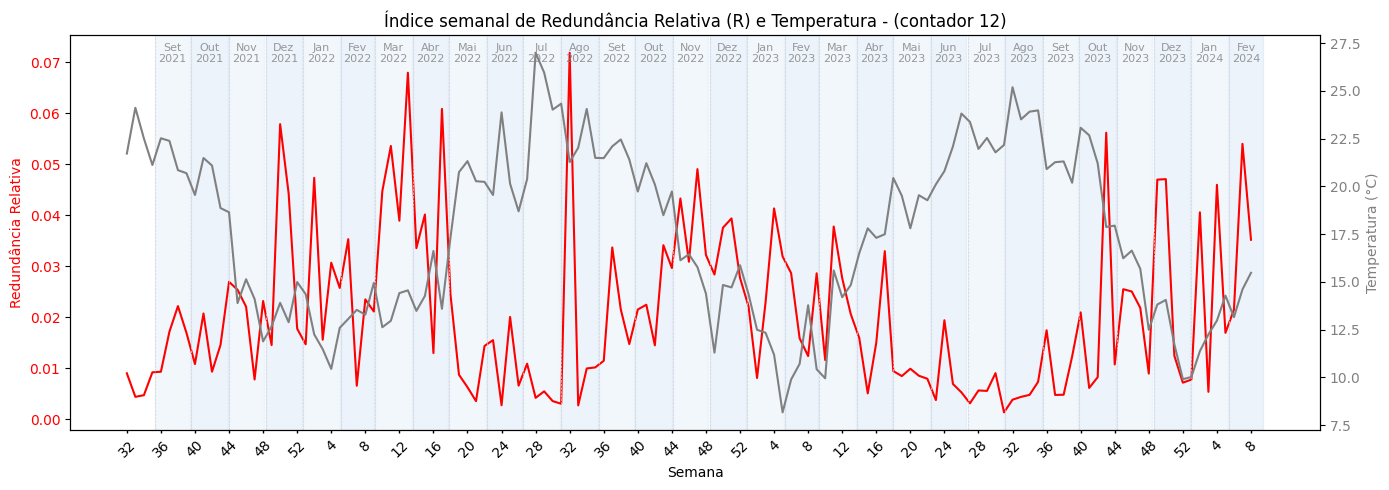

In [38]:
locale.setlocale(locale.LC_TIME, 'pt_PT.UTF-8')
df_sorted_12 = df_merged_count12.sort_values('semana_data')
df_sorted_12 = df_sorted_12.sort_values('semana_data')
df_sorted_12['semana_ano'] = df_sorted_12['semana_data'].dt.isocalendar().week

# Criar figura e eixo principal
fig, ax1 = plt.subplots(figsize=(14, 5))
ax1.grid(False)

# Plotar o índice de Gini no eixo da esquerda
ax1.plot(df_sorted_12['semana_data'], df_sorted_12['R'], color='red', label='R')
ax1.set_xlabel('Semana')
ax1.set_ylabel('Redundância Relativa', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Criar segundo eixo Y (compartilhando o eixo X)
ax2 = ax1.twinx()
ax2.plot(df_sorted_12['semana_data'], df_sorted_12['temp'], color='grey', label='Temperatura')
ax2.set_ylabel('Temperatura (°C)', color='grey')
ax2.tick_params(axis='y', labelcolor='grey')


# Título e layout
datas = df_sorted_12['semana_data']
min_data = datas.min()
max_data = datas.max()
inicio_mes = pd.date_range(start=min_data, end=max_data, freq='MS')

for i, start in enumerate(inicio_mes):
    end = start + pd.offsets.MonthEnd(1)
    cor = (0.5, 0.7, 0.9, 0.1 + 0.05 * (i % 2))  # tons azul pastel alternados
    ax1.axvspan(start, end, color=cor)
    ax1.axvline(start, color='lightgrey', linestyle='--', linewidth=0.5)

        # Nome do mês
    mid = start + (end - start) / 2
    nome_mes = f"{start.strftime('%b').capitalize()}\n{start.year}"
    ax1.text(mid, ax1.get_ylim()[1]*0.98, nome_mes,
            ha='center', va='top', fontsize=8, color='gray', alpha=0.8)

semanas_para_ticks = df_sorted_12[df_sorted_12['semana_ano'] % 4 == 0]
ticks_locs = mdates.date2num(semanas_para_ticks['semana_data'])
ticks_labels = [str(w) for w in semanas_para_ticks['semana_ano']]
    
ax1.set_xticks(ticks_locs)
ax1.set_xticklabels(ticks_labels, rotation=45)
ax1.tick_params(axis='x', which='major', length=2, width=1)
plt.title('Índice semanal de Redundância Relativa (R) e Temperatura - (contador 12)')
fig.tight_layout()
plt.show()


In [18]:
from scipy.stats import pearsonr

corr_coef, p_value = pearsonr(df_merged_count12['temp'], df_merged_count12['R'])

print(f"Coeficiente de correlação de Pearson: {corr_coef:.4f}")
print(f"P-valor: {p_value:.4e}")

Coeficiente de correlação de Pearson: -0.4898
P-valor: 2.1818e-09


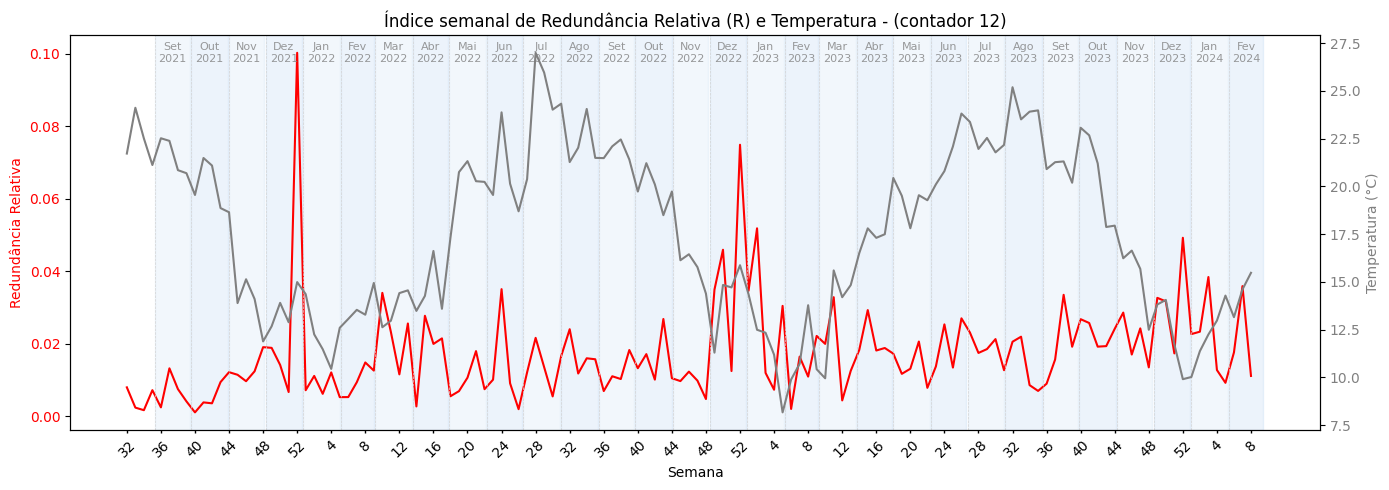

In [39]:
locale.setlocale(locale.LC_TIME, 'pt_PT.UTF-8')
df_sorted_8 = df_merged_count8.sort_values('semana_data')
df_sorted_8 = df_sorted_8.sort_values('semana_data')
df_sorted_8['semana_ano'] = df_sorted_8['semana_data'].dt.isocalendar().week

# Criar figura e eixo principal
fig, ax1 = plt.subplots(figsize=(14, 5))
ax1.grid(False)

# Plotar o índice de Gini no eixo da esquerda
ax1.plot(df_sorted_8['semana_data'], df_sorted_8['R'], color='red', label='R')
ax1.set_xlabel('Semana')
ax1.set_ylabel('Redundância Relativa', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Criar segundo eixo Y (compartilhando o eixo X)
ax2 = ax1.twinx()
ax2.plot(df_sorted_8['semana_data'], df_sorted_8['temp'], color='grey', label='Temperatura')
ax2.set_ylabel('Temperatura (°C)', color='grey')
ax2.tick_params(axis='y', labelcolor='grey')


# Título e layout
datas = df_sorted_8['semana_data']
min_data = datas.min()
max_data = datas.max()
inicio_mes = pd.date_range(start=min_data, end=max_data, freq='MS')

for i, start in enumerate(inicio_mes):
    end = start + pd.offsets.MonthEnd(1)
    cor = (0.5, 0.7, 0.9, 0.1 + 0.05 * (i % 2))  # tons azul pastel alternados
    ax1.axvspan(start, end, color=cor)
    ax1.axvline(start, color='lightgrey', linestyle='--', linewidth=0.5)

        # Nome do mês
    mid = start + (end - start) / 2
    nome_mes = f"{start.strftime('%b').capitalize()}\n{start.year}"
    ax1.text(mid, ax1.get_ylim()[1]*0.98, nome_mes,
            ha='center', va='top', fontsize=8, color='gray', alpha=0.8)

semanas_para_ticks = df_sorted_8[df_sorted_8['semana_ano'] % 4 == 0]
ticks_locs = mdates.date2num(semanas_para_ticks['semana_data'])
ticks_labels = [str(w) for w in semanas_para_ticks['semana_ano']]
    
ax1.set_xticks(ticks_locs)
ax1.set_xticklabels(ticks_labels, rotation=45)
ax1.tick_params(axis='x', which='major', length=2, width=1)
plt.title('Índice semanal de Redundância Relativa (R) e Temperatura - (contador 12)')
fig.tight_layout()
plt.show()

In [28]:
from scipy.stats import pearsonr

corr_coef, p_value = pearsonr(df_merged_count8['temp'], df_merged_count8['R'])

print(f"Coeficiente de correlação de Pearson: {corr_coef:.4f}")
print(f"P-valor: {p_value:.4e}")

Coeficiente de correlação de Pearson: -0.1881
P-valor: 3.0104e-02
